# Robustness to PID Parameter Changes

In [332]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from trajectories import nasa_wp
from parameters import pid_params

In [333]:
best_agent = PIDAgent()
pid_parameters = pid_params()

best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters':pid_parameters}

In [334]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
triangle_wpts = np.array([[50,100,30], [-50, 100,30], [0,0,30]])


In [335]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [336]:
def toc(tte: np.ndarray):
    corridor = 2
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [337]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [338]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    wp = [(150,0,30)]
    env = env_selector.get_env("default", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=False)
    env.base_env.max_velocity = 10
    
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle,
                      other_vars=('reward', 'next_wp', 'wind', 'motor'))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, wind=env.base_env.wind_y, motor=env.base_env.vehicle.speeds)

    log.done_logging()
    return log, info

In [339]:
wind_mag = 8

## With tuned parameters

In [340]:
log, info = run_trajectory(env_selector, [(0,0),(wind_mag,wind_mag),(0,0)], best_agent, best_params)

Text(0.5, 1.0, 'X and Y position under 8 m/s North Wind - Tuned PID')

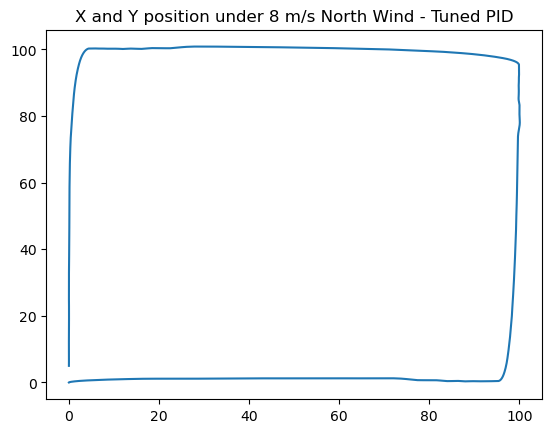

In [341]:
plt.plot(log.x, log.y)
plt.title(f"X and Y position under {wind_mag} m/s North Wind - Tuned PID")

## With low parameters

In [359]:
pos_mult = 0.2
vel_mult = 0.2

In [360]:
best_agent = PIDAgent()
pid_parameters = pid_params(
    pos_p=[pos_mult*0.3, pos_mult*0.3, 0.2],
    vel_p=[vel_mult*1, vel_mult*1, 100],
    vel_i=[vel_mult*0.1, vel_mult*0.1, 0]
)

best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters':pid_parameters}

In [361]:
log, info = run_trajectory(env_selector, [(0,0),(wind_mag,wind_mag),(0,0)], best_agent, best_params)

Text(0.5, 1.0, 'X and Y position under 8 m/s North Wind - 80% lower PID')

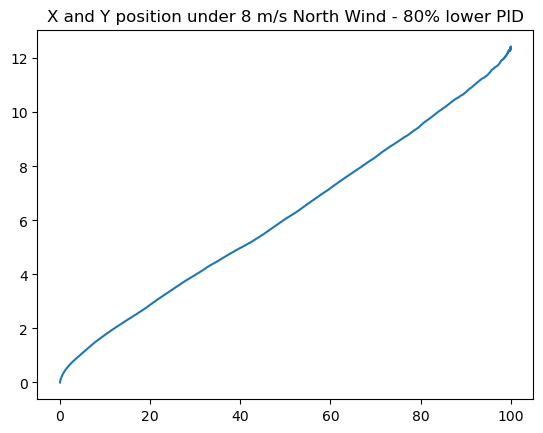

In [362]:
plt.plot(log.x, log.y)
plt.title(f"X and Y position under {wind_mag} m/s North Wind - {int((1-pos_mult)*100)}% lower PID")

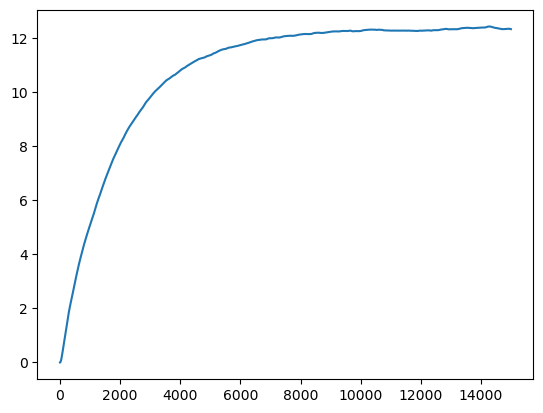

In [363]:
plt.plot(log.y)

## Higher PID

In [346]:
pos_mult = 10
vel_mult = 10

In [347]:
best_agent = PIDAgent()
pid_parameters = pid_params(
    pos_p=[pos_mult*0.3, pos_mult*0.3, 0.2],
    vel_p=[vel_mult*1, vel_mult*1, 100],
    vel_i=[vel_mult*0.1, vel_mult*0.1, 0]
)

best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters':pid_parameters}

In [348]:
log, info = run_trajectory(env_selector, [(0,0),(wind_mag,wind_mag),(0,0)], best_agent, best_params)

Text(0.5, 1.0, 'X and Y position under 8 m/s North Wind - 900% higher PID')

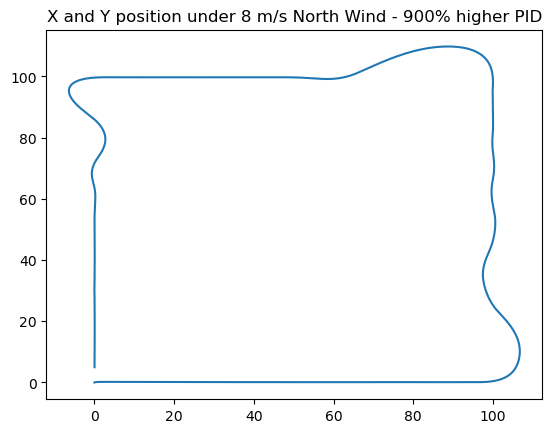

In [349]:
plt.plot(log.x, log.y)
plt.title(f"X and Y position under {wind_mag} m/s North Wind - {int((pos_mult-1)*100)}% higher PID")